We will predict positive and negative reviews on the IMDB dataset using 2 models :
1. A simple model with 1 layer
2. A model consisting of 1D CNNs

Further, we will get the embeddings, and we can view them on [Embedding Projector by Tensorflow](https://projector.tensorflow.org)

In [3]:
'''
Importing important libraries
'''

import io
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [4]:
'''
tfds.load() is used to get the IMDB dataset
name = 'imdb_reviews/subwords8k'
We will use tfds.Split and use TRAIN, TEST to get the training and testing data
with_info will return tfds.core.DatasetInfo which has info associated with the builder
as_supervised will make tf.data.Dataset have 2-tuple structure (input, label)
'''
def get_data_batches():
    (trainset, testset), info = tfds.load('imdb_reviews/subwords8k',
                                           split=(tfds.Split.TRAIN, tfds.Split.TEST),
                                           with_info=True, as_supervised=True)

    encoder = info.features['text'].encoder
    padded_shapes = ([None], ())
    train_batches = trainset.shuffle(1000).padded_batch(10, padded_shapes)
    test_batches = testset.shuffle(1000).padded_batch(10, padded_shapes)

    return train_batches, test_batches, encoder

In [5]:
'''
Function to plot the accuracy
'''
def plot_data(history):
    history_dict = history.history
    train_acc = history_dict['accuracy']
    validation_acc = history_dict['val_accuracy']
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 9))
    plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, validation_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim((0.4, 1))
    plt.show()

Our first model is a simple model having the embeddings followed by a global average pooling and the output

The second model utilizes 1D Convolutions and additional dense layer

In [6]:
def get_model1(encoder, embedding_dim=16):
    model1 = keras.Sequential([
                layers.Embedding(encoder.vocab_size, embedding_dim),
                layers.GlobalAveragePooling1D(),
                layers.Dense(1, activation='sigmoid')
    ])

    model1.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model1

In [7]:
def get_model2(encoder, embedding_dim=16):
  model2 = keras.Sequential([
              layers.Embedding(encoder.vocab_size, embedding_dim),
              layers.Conv1D(128, 5, activation='relu'),
              layers.GlobalAveragePooling1D(),
              layers.Dense(64, activation='relu'),
              layers.Dense(1, activation='sigmoid')                       
  ])
  model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model2

In [8]:
def get_embeddings(model, encoder):
    output_vectors = io.open('vectors.tsv', 'w', encoding='utf-8')
    output_metadata = io.open('meta.tsv', 'w', encoding='utf-8')
    weights = model.layers[0].get_weights()[0]
    for i, word in enumerate(encoder.subwords):
        vec = weights[i+1]
        output_metadata.write(word + '\n')
        output_vectors.write('\t'.join([str(x) for x in vec]) + '\n')

    output_vectors.close()
    output_metadata.close()


In [9]:
train_batches, test_batches, encoder = get_data_batches()
model1 = get_model1(encoder)
print(model1.summary())

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteO8YI5H/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteO8YI5H/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteO8YI5H/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/10
2500/2500 [==============================] - 16s 5ms/step - loss: 0.6748 - accuracy: 0.6253 - val_loss: 0.5676 - val_accuracy: 0.8000
Epoch 2/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.5083 - accuracy: 0.8127 - val_loss: 0.4534 - val_accuracy: 0.8150
Epoch 3/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.3879 - accuracy: 0.8689 - val_loss: 0.3444 - val_accuracy: 0.8900
Epoch 4/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.3241 - accuracy: 0.8886 - val_loss: 0.3410 - val_accuracy: 0.8500
Epoch 5/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.2855 - accuracy: 0.9034 - val_loss: 0.3638 - val_accuracy: 0.8700
Epoch 6/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.2595 - accuracy: 0.9134 - val_loss: 0.2634 - val_accuracy: 0.8800
Epoch 7/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.2380 - accuracy: 0.9210 - val_loss: 0.3129 - val_ac

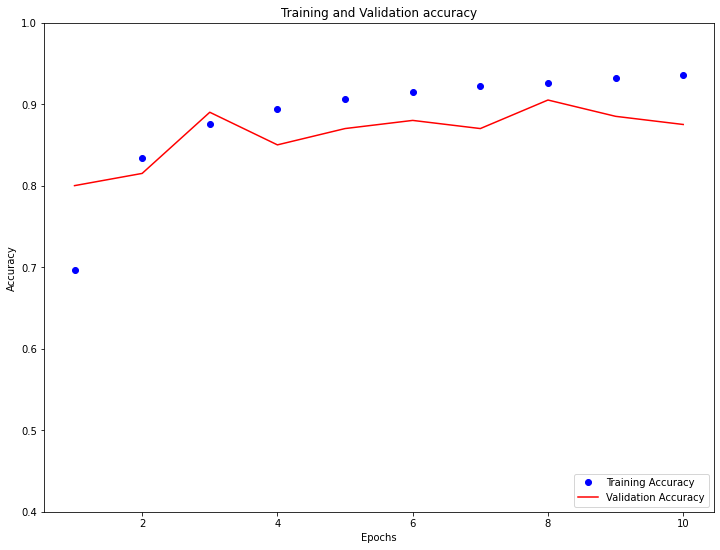

In [10]:
history1 = model1.fit(train_batches, epochs=10, validation_data=test_batches,
                    validation_steps=20)
plot_data(history1)

In [11]:
model2 = get_model2(encoder)
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         10368     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 149,649
Trainable params: 149,649
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/10
2500/2500 [==============================] - 32s 10ms/step - loss: 0.4762 - accuracy: 0.7496 - val_loss: 0.2869 - val_accuracy: 0.8850
Epoch 2/10
2500/2500 [==============================] - 17s 7ms/step - loss: 0.2126 - accuracy: 0.9199 - val_loss: 0.2918 - val_accuracy: 0.8800
Epoch 3/10
2500/2500 [==============================] - 16s 7ms/step - loss: 0.1697 - accuracy: 0.9387 - val_loss: 0.2951 - val_accuracy: 0.9050
Epoch 4/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1294 - accuracy: 0.9551 - val_loss: 0.4206 - val_accuracy: 0.8750
Epoch 5/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.0978 - accuracy: 0.9679 - val_loss: 0.4708 - val_accuracy: 0.8400
Epoch 6/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.0719 - accuracy: 0.9749 - val_loss: 0.9381 - val_accuracy: 0.8400
Epoch 7/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.0521 - accuracy: 0.9836 - val_loss: 0.7394 - val_a

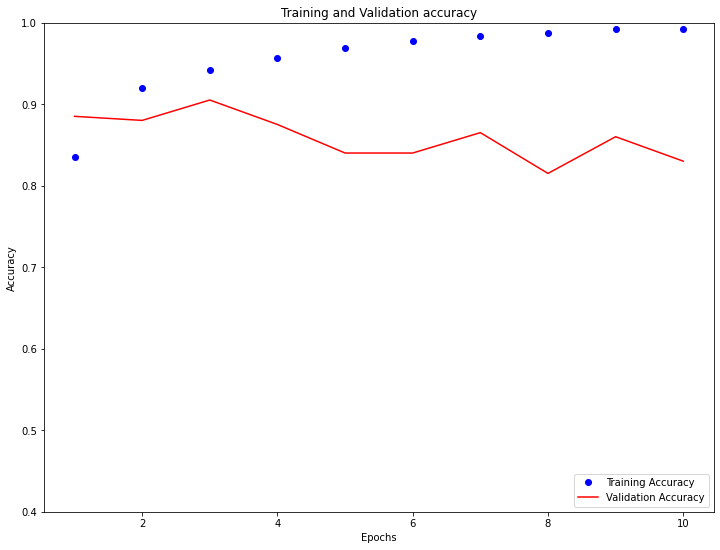

In [13]:
history2 = model2.fit(train_batches, epochs=10, validation_data=test_batches,
                    validation_steps=20)
plot_data(history2)

We can clearly see that with 10 epochs and the given settings, the model overfitted heavily

In [14]:
model3 = get_model2(encoder)
history2_1 = model3.fit(train_batches, epochs=5, validation_data=test_batches,
                    validation_steps=10)

Epoch 1/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.4805 - accuracy: 0.7392 - val_loss: 0.3394 - val_accuracy: 0.8700
Epoch 2/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2124 - accuracy: 0.9195 - val_loss: 0.4232 - val_accuracy: 0.8300
Epoch 3/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1644 - accuracy: 0.9393 - val_loss: 0.1999 - val_accuracy: 0.9200
Epoch 4/5
2500/2500 [==============================] - 15s 6ms/step - loss: 0.1281 - accuracy: 0.9550 - val_loss: 0.5013 - val_accuracy: 0.8300
Epoch 5/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.0998 - accuracy: 0.9665 - val_loss: 0.4864 - val_accuracy: 0.8400


Let's increase the embedding dimensions and see

In [16]:
model4 = get_model2(encoder, embedding_dim=20)
history4 = model4.fit(train_batches, epochs=5, validation_data=test_batches,
                    validation_steps=20)

Epoch 1/5
2500/2500 [==============================] - 26s 10ms/step - loss: 0.4912 - accuracy: 0.7306 - val_loss: 0.3279 - val_accuracy: 0.8850
Epoch 2/5
2500/2500 [==============================] - 18s 7ms/step - loss: 0.2123 - accuracy: 0.9175 - val_loss: 0.4001 - val_accuracy: 0.8450
Epoch 3/5
2500/2500 [==============================] - 17s 7ms/step - loss: 0.1570 - accuracy: 0.9418 - val_loss: 0.2761 - val_accuracy: 0.9000
Epoch 4/5
2500/2500 [==============================] - 16s 7ms/step - loss: 0.1149 - accuracy: 0.9602 - val_loss: 0.3572 - val_accuracy: 0.8850
Epoch 5/5
2500/2500 [==============================] - 17s 7ms/step - loss: 0.0865 - accuracy: 0.9720 - val_loss: 0.7267 - val_accuracy: 0.8250


We can see the overfitting clearly in this model.